# **Proyek Machine Learning Terapan**



*   Nama        : Muhammad Khalish
*   E-mail      : khalish.21muhammad07@gmail.com
*   Dicoding ID : https://www.dicoding.com/users/mkhlst/
*   Topic       : Workout Recommendation



# **Deskripsi proyek**

Proyek ini akan menganalisa dataset anggota gym yang melakukan workout dan membuat model yang dapat rekomendasi workout tertentu kepada user dengan metode `Content Based Filtering (CBF)`, `Colaborative Filtering (CF)`, dan gabungan keduanya (Hybrid).

# **Import library yang dibutuhkan**

In [ ]:
!pip install -q kaggle

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357267 sha256=18b75c6af5fef11851a299f1c64ac1a6b00a409703fdeaac15cf51afea579f5a
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
# Import load data library
import os
import random
import pandas as pd
import numpy as np
import surprise
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset, SVD
from surprise import accuracy

# **Data Understanding**

Merupakan proses untuk memahami informasi dalam data dan menentukan kualitas data

## **Data Loading**

Merupakan proses untuk memuat dataset agar dapat digunakan. Dataset yang digunakan bersumber dari `Kaggle` yakni `gym_members_exercise_dataset.csv` dengan author `Vala Khorasani`. Informasi lebih lanjut dapat dilihat sebagai berikut.

**Informasi Dataset**

| Jenis | Keterangan |
| ------ | ------ |
| Title | Gym Members Exercise Dataset |
| Source | [Kaggle](https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset) |
| Maintainer | [Vala Khorasani ⚡](https://www.kaggle.com/valakhorasani) |
| License | Apache 2.0 |
| Visibility | Public |
| Tags | Computer Science, Exercise, Data Visualization, Classification, Exploratory Data Analysis |
| Usability | 10.00 |

In [ ]:
# Membuat direktori baru bernama kaggle
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke direktori kaggle
!mv kaggle.json ~/.kaggle/kaggle.json

# Mengubah permission berkas
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d valakhorasani/gym-members-exercise-dataset
!kaggle datasets download -d bitanianielsen/nutrition-daily-meals-in-diseases-cases

# Ekstrak berkas zip
!unzip /content/gym-members-exercise-dataset.zip
!unzip /content/nutrition-daily-meals-in-diseases-cases.zip

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset
License(s): apache-2.0
  0% 0.00/21.6k [00:00<?, ?B/s]
100% 21.6k/21.6k [00:00<00:00, 25.3MB/s]
Dataset URL: https://www.kaggle.com/datasets/bitanianielsen/nutrition-daily-meals-in-diseases-cases
License(s): other
  0% 0.00/237k [00:00<?, ?B/s]
100% 237k/237k [00:00<00:00, 21.0MB/s]
Archive:  /content/gym-members-exercise-dataset.zip
  inflating: gym_members_exercise_tracking.csv  
Archive:  /content/nutrition-daily-meals-in-diseases-cases.zip
  inflating: Food_and_Nutrition__.csv  
  inflating: detailed_meals_macros_.csv  
  inflating: detailed_meals_macros_CLEANED.csv  


## **Exploratory Data Analysis (EDA)**

Exploratory data analysis atau sering disingkat EDA merupakan proses investigasi awal pada data untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data

### **Pengecekan Dataset**

Pengecekan informasi dari dataset mengenai sampel data, jumlah kolom, nama kolom, jumlah data per kolom, tipe data.

In [ ]:
gym = pd.read_csv('/content/gym_members_exercise_tracking.csv')

In [ ]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

Berdasarkan tabel diatas, terdapat 15 Kolom dan 973 baris data.
- `Age` -> Umur gym member
- `Gender` -> Jenis kelamin gym member
- `Weight (kg)` -> Berat (dalam `kg`) gym member
- `Height (m)` -> Tinggi (dalam `m`) gym member
- `Max_BPM` -> maksimal BPM (Beat Per Minute) gym member saat sesi
- `Avg_BPM` -> Rata-rata BPM (Beat Per Minute) gym member saat sesi
- `Resting_BPM` -> BPM (Beat Per Minute) gym member sebelum sesi
- `Session_Duration (hours)` -> Durasi sesi dalam jam
- `Calories_Burned` -> jumlah kalori yang dibakar tiap sesi
- `Workout_Type` -> kategori workout yang dilakukan
- `Fat_Percentage` -> persentase lemak gym member
- `Water_Intake (liters)` -> kebutuhan air harian (dalam `liter`) saat sesi
- `Workout_Frequency (days/week)` -> jumlah sesi workout per minggu
- `Experience_Level` -> tingkat pengalaman member, (1) Beginner, (2) Intermediate, dan (3) Expert
- `BMI` -> Body Mass Index, dihitung dari tinggi dan berat

# **Data Preparation**

Data Preparation merupakan proses untuk mempersiapkan data sebelum dilakukan tahap pembuatan model machine learning. Pada tahap ini dilakukan proses `Feature Engineering`, `Data Cleaning`, dan `Data Splitting`.

## **Data Cleaning**

Data Cleaning merupakan Proses untuk `membersihkan data dari missing value` dan `data duplikat` yang dapat mempengaruhi peforma model *machine learning*

### **Menangani Missing Value**

In [ ]:
gym.shape

(973, 15)

In [ ]:
gym.isnull().sum()

,0
Age,0
Gender,0
Weight (kg),0
Height (m),0
Max_BPM,0
Avg_BPM,0
Resting_BPM,0
Session_Duration (hours),0
Calories_Burned,0
Workout_Type,0


### **Pengecekan dan Pembersihan data duplikat**

In [ ]:
print('Jumlah data duplikat pada user:', gym.duplicated().sum())

Jumlah data duplikat pada user: 0


In [ ]:
gym = gym.drop_duplicates()
print('Jumlah data duplikat pada user:', gym.duplicated().sum())

Jumlah data duplikat pada user: 0


## **Feature Engineering**

Feature Engineering merupakan proses transformasi data dengan `menambah`, `mengubah` dan `menghapus` beberapa fitur agar kualitas data menjadi lebih baik dan dapat diterima oleh model machine learning nantinya.

In [ ]:
gym['User_ID'] = range(1, len(gym) + 1)
gym.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,User_ID
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20,1
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00,2
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71,3
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41,4
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39,5


Terdapat beberapa fitur pada data diatas yang tidak relevan seperti `Max_BPM`, `Resting_BPM`, `Water_Intake (liters)`, `Experience_Level`, `Workout_Type`, `BMI`, dan `Fat_Percentage` dan juga ada nama fitur yang perlu kita ubah agar lebih simpel untuk dikenali. maka dari itu, kita perlu menggunakan fungsi `drop()` dan `rename()` untuk melakukan kedua hal itu.

In [ ]:
gym = gym.drop(columns=['Max_BPM','Resting_BPM', 'Water_Intake (liters)', 'Experience_Level', 'Workout_Type', 'BMI', 'Fat_Percentage'])
gym = gym.rename(columns={'user_id':'User_ID', 'date':'Date', 'Weight (kg)':'Weight',
                            'Height (m)':'Height', 'Session_Duration (hours)':'Duration',
                            'Workout_Frequency (days/week)':'Frequency'})

Penambahan fitur `BMI` digunakan untuk mengklasifikaskan goal workout yang ingin dicapai user dimana data BMI didapat dari perhitungan berat badan `Weight` dibagi dengan kuadrat tinggi badan `Height`.

In [ ]:
gym['BMI'] = (gym['Weight'] / (gym['Height'] ** 2)).round(2).astype(float)
gym.head()

,Age,Gender,Weight,Height,Avg_BPM,Duration,Calories_Burned,Frequency,User_ID,BMI
0,56,Male,88.3,1.71,157,1.69,1313.0,4,1,30.20
1,46,Female,74.9,1.53,151,1.30,883.0,4,2,32.00
2,32,Female,68.1,1.66,122,1.11,677.0,4,3,24.71
3,25,Male,53.2,1.70,164,0.59,532.0,3,4,18.41
4,38,Male,46.1,1.79,158,0.64,556.0,3,5,14.39


Workout goal diklasifikasikan berdasarkan index BMI dimana jika melebihi indeks normal `18.5 - 25` makan diklasifikasikan dengan penurunan berat badan `Weight Loss`, jika kurang dari indeks normal diklasifikasikan penambahan berat badan `Weight Gain` dan jika berada pada indeks normal diklasifikasikan `Flexibility`.

In [ ]:
def classify_bmi(bmi):
    if bmi >= 25:
        return 'Weight Loss'
    elif 18.5 <= bmi < 25:
        return 'Flexibility'
    else:
        return 'Weight Gain'

# Terapkan fungsi classify_bmi ke setiap baris kolom BMI
gym['Goal'] = gym['BMI'].apply(classify_bmi)

# Lihat hasilnya
gym.head()

,Age,Gender,Weight,Height,Avg_BPM,Duration,Calories_Burned,Frequency,User_ID,BMI,Goal
0,56,Male,88.3,1.71,157,1.69,1313.0,4,1,30.20,Weight Loss
1,46,Female,74.9,1.53,151,1.30,883.0,4,2,32.00,Weight Loss
2,32,Female,68.1,1.66,122,1.11,677.0,4,3,24.71,Flexibility
3,25,Male,53.2,1.70,164,0.59,532.0,3,4,18.41,Weight Gain
4,38,Male,46.1,1.79,158,0.64,556.0,3,5,14.39,Weight Gain


Selanjutnya, kita memberikan label jenis dan nama workout beserta level pengalaman pengguna dengan memberikan data dictionary yang diinginkan dan sekaligus mengklasifikasikan berdasarkan tujuan dan level pengalamannya user.

In [ ]:
goal_type = {
    'Weight Loss': ['Cardio', 'HIIT', 'Flexibility'],
    'Weight Gain': ['Strength', 'Flexibility'],
    'Flexibility': ['Flexibility']
}
name = {
    'Cardio': ['Running', 'Walking', 'Cycling', 'Marathon'],
    'HIIT': ['Burpess', 'High Knees', 'Jump Squats', 'Mountain Climbing'],
    'Flexibility': ['Yoga', 'Zumba', 'Pilates'],
    'Strength': ['Bench Press', 'Deadlifts', 'Squat', 'Plank', 'Push Up']
}
level = {
    'Cardio': {'Marathon': 3, 'Running': 2, 'Walking': 1, 'Cycling': 2},
    'HIIT': {'Burpess': 3, 'High Knees': 2, 'Jump Squats': 2, 'Mountain Climbing': 3},
    'Flexibility': {'Yoga': 1, 'Zumba': 2, 'Pilates': 3},
    'Strength': {'Bench Press': 3, 'Deadlifts': 3, 'Squat': 2, 'Plank': 1, 'Push Up':1}
}
def get_workout_and_level(row):
    goal = row['Goal']
    workout_types = goal_type.get(goal, [])

    if workout_types:
        workout_type = workout_types[0]
        workout_name = random.choice(name.get(workout_type, []))
        experience_level = level.get(workout_type, {}).get(workout_name, 'Unknown')
    else:
        workout_type = 'Unknown'
        workout_name = 'Unknown'
        experience_level = 'Unknown'

    return pd.Series([workout_type, workout_name, experience_level])


gym[['Workout_Type', 'Workout_Name', 'Experience_Level']] = gym.apply(get_workout_and_level, axis=1)
gym['Workout_ID'] = gym['Workout_Name'].astype('category').cat.codes + 1
print(gym.head())

   Age  Gender  Weight  Height  Avg_BPM  Duration  Calories_Burned  Frequency  \
0   56    Male    88.3    1.71      157      1.69           1313.0          4   
1   46  Female    74.9    1.53      151      1.30            883.0          4   
2   32  Female    68.1    1.66      122      1.11            677.0          4   
3   25    Male    53.2    1.70      164      0.59            532.0          3   
4   38    Male    46.1    1.79      158      0.64            556.0          3   

   User_ID    BMI         Goal Workout_Type Workout_Name  Experience_Level  \
0        1  30.20  Weight Loss       Cardio      Walking                 1   
1        2  32.00  Weight Loss       Cardio     Marathon                 3   
2        3  24.71  Flexibility  Flexibility        Zumba                 2   
3        4  18.41  Weight Gain     Strength        Squat                 2   
4        5  14.39  Weight Gain     Strength      Push Up                 1   

   Workout_ID  
0          10  
1           

**Encoding Feature**

kita perlu mengubah label `gender` dari tipe data string menjadi numerik dengan menggunakan fungsi `replace()` agar dapat digunakan.

In [ ]:
gym['Gender'] = gym['Gender'].replace({'Male': 0, 'Female': 1})
gym.head()

<ipython-input-17-7948b5787b7f>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gym['Gender'] = gym['Gender'].replace({'Male': 0, 'Female': 1})


,Age,Gender,Weight,Height,Avg_BPM,Duration,Calories_Burned,Frequency,User_ID,BMI,Goal,Workout_Type,Workout_Name,Experience_Level,Workout_ID
0,56,0,88.3,1.71,157,1.69,1313.0,4,1,30.20,Weight Loss,Cardio,Walking,1,10
1,46,1,74.9,1.53,151,1.30,883.0,4,2,32.00,Weight Loss,Cardio,Marathon,3,4
2,32,1,68.1,1.66,122,1.11,677.0,4,3,24.71,Flexibility,Flexibility,Zumba,2,12
3,25,0,53.2,1.70,164,0.59,532.0,3,4,18.41,Weight Gain,Strength,Squat,2,9
4,38,0,46.1,1.79,158,0.64,556.0,3,5,14.39,Weight Gain,Strength,Push Up,1,7


## **Data Splitting**

*Data Splitting* merupkan proses pembagian data berdasarkan kebutuhan untuk sistem rekomendasi. pada proses ini, data dibagi menjadi 3 yaitu `Data User` yang berisi ragam informasi mengenai user, `Data Workout` yang berisi ragam informasi mengenai Workout, dan `Data Feedback` sebagai data `rating implisit`. Pada data feedback, fungsi `MinMaxScaler()` digunakan untuk normalisasi data numerik dalam rentang 0 hingga 1 agar didapatkan `aggregate` yang menjadi rata-rata untuk rating implisit dari data ini.

### **Data User**

In [ ]:
user = pd.DataFrame({
    'User_ID': gym['User_ID'],
    'Age': gym['Age'],
    'Gender': gym['Gender'],
    'Height': gym['Height'],
    'Weight': gym['Weight'],
    'BMI': gym['BMI'],
    'Goal': gym['Goal'],
})
user = user.dropna()
user.head()

,User_ID,Age,Gender,Height,Weight,BMI,Goal
0,1,56,0,1.71,88.3,30.20,Weight Loss
1,2,46,1,1.53,74.9,32.00,Weight Loss
2,3,32,1,1.66,68.1,24.71,Flexibility
3,4,25,0,1.70,53.2,18.41,Weight Gain
4,5,38,0,1.79,46.1,14.39,Weight Gain


In [ ]:
user['Goal'].value_counts()

,count
Goal,
Weight Loss,435
Flexibility,370
Weight Gain,168


### **Data Workout**

In [ ]:
fit = pd.DataFrame({
    'Workout_ID': gym['Workout_ID'],
    'Workout_Name': gym['Workout_Name'],
    'Workout_Type': gym['Workout_Type'],
    'Experience_Level': gym['Experience_Level']
})
fit.head()

,Workout_ID,Workout_Name,Workout_Type,Experience_Level
0,10,Walking,Cardio,1
1,4,Marathon,Cardio,3
2,12,Zumba,Flexibility,2
3,9,Squat,Strength,2
4,7,Push Up,Strength,1


In [ ]:
fit['Workout_Name'].value_counts()

,count
Workout_Name,
Walking,130
Zumba,129
Yoga,124
Pilates,117
Marathon,107
Cycling,101
Running,97
Deadlifts,42
Push Up,35


### **Data Feedback**

In [ ]:
fb = pd.DataFrame({
    'User_ID': gym['User_ID'],
    'Workout_ID': gym['Workout_ID'],
    'Workout_Name': gym['Workout_Name'],
    'Workout_Type': gym['Workout_Type'],
    'Duration': gym['Duration'],
    'Calories_Burned': gym['Calories_Burned'],
    'Avg_BPM': gym['Avg_BPM'],
    'Frequency': gym['Frequency'],
    'Level': gym['Experience_Level']
})
fb

,User_ID,Workout_ID,Workout_Name,Workout_Type,Duration,Calories_Burned,Avg_BPM,Frequency,Level
0,1,10,Walking,Cardio,1.69,1313.0,157,4,1
1,2,4,Marathon,Cardio,1.30,883.0,151,4,3
2,3,12,Zumba,Flexibility,1.11,677.0,122,4,2
3,4,9,Squat,Strength,0.59,532.0,164,3,2
4,5,7,Push Up,Strength,0.64,556.0,158,3,1
...,...,...,...,...,...,...,...,...,...
968,969,8,Running,Cardio,1.57,1364.0,158,4,2
969,970,10,Walking,Cardio,1.38,1260.0,166,2,1
970,971,5,Pilates,Flexibility,1.72,929.0,120,5,3
971,972,8,Running,Cardio,1.10,883.0,146,3,2


In [ ]:
fb[['Duration', 'Calories_Burned', 'Avg_BPM', 'Frequency', 'Level']] = MinMaxScaler().fit_transform(fb[['Duration', 'Calories_Burned',
                                                                                                        'Avg_BPM', 'Frequency', 'Level']]).round(2)
fb['Aggregate'] = ((fb['Duration']  + fb['Calories_Burned'] + fb['Avg_BPM'] + fb['Frequency'] + fb['Level'])/5).round(2)
fb['Preference_Vector'] = fb[['Duration', 'Calories_Burned', 'Avg_BPM', 'Frequency', 'Level']].apply(
    lambda row: row.values, axis=1)
final_fb = fb
final_fb

,User_ID,Workout_ID,Workout_Name,Workout_Type,Duration,Calories_Burned,Avg_BPM,Frequency,Level,Aggregate,Preference_Vector
0,1,10,Walking,Cardio,0.79,0.68,0.76,0.67,0.0,0.58,"[0.79, 0.68, 0.76, 0.67, 0.0]"
1,2,4,Marathon,Cardio,0.53,0.39,0.63,0.67,1.0,0.64,"[0.53, 0.39, 0.63, 0.67, 1.0]"
2,3,12,Zumba,Flexibility,0.41,0.25,0.04,0.67,0.5,0.37,"[0.41, 0.25, 0.04, 0.67, 0.5]"
3,4,9,Squat,Strength,0.06,0.15,0.90,0.33,0.5,0.39,"[0.06, 0.15, 0.9, 0.33, 0.5]"
4,5,7,Push Up,Strength,0.09,0.17,0.78,0.33,0.0,0.27,"[0.09, 0.17, 0.78, 0.33, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...
968,969,8,Running,Cardio,0.71,0.72,0.78,0.67,0.5,0.68,"[0.71, 0.72, 0.78, 0.67, 0.5]"
969,970,10,Walking,Cardio,0.59,0.65,0.94,0.00,0.0,0.44,"[0.59, 0.65, 0.94, 0.0, 0.0]"
970,971,5,Pilates,Flexibility,0.81,0.42,0.00,1.00,1.0,0.65,"[0.81, 0.42, 0.0, 1.0, 1.0]"
971,972,8,Running,Cardio,0.40,0.39,0.53,0.33,0.5,0.43,"[0.4, 0.39, 0.53, 0.33, 0.5]"


# **Model Development**

Pada taap ini, model yang dibangun ada 3 yaitu `Content-Based Filtering` (CBF), `Collaborative Filtering` (CF) dan `Hybrid Recommendation`.

## **Content-Based Filtering**

### **Cosine Similarity**

Pada tahap ini, kita menggunakan fungsi `cosine_similarity(feature)` untuk menghitung kemiripan antar fitur. Dan juga, fitur yang digunakan pada proyek ini yakni `durasi`, `jumlah kalori yang terbakar`, `rata-rata BPM`, `frekuensi` dan `level pengalaman user`.

In [ ]:
features = final_fb[['Duration', 'Calories_Burned', 'Avg_BPM', 'Frequency', 'Level']]

sim_scores = cosine_similarity(features)
print(f'Similarity Scores: ', sim_scores.shape)
print(f'-----'*6)
# Tampilkan hasil similarity scores
print("Cosine Similarity antara workout dan preferensi pengguna:\n", sim_scores)

Similarity Scores:  (973, 973)
------------------------------
Cosine Similarity antara workout dan preferensi pengguna:
 [[1.         0.73443676 0.69383178 ... 0.65217193 0.84972359 0.58074994]
 [0.73443676 1.         0.88484654 ... 0.8907702  0.96352776 0.85403093]
 [0.69383178 0.88484654 1.         ... 0.98960021 0.80068613 0.51592485]
 ...
 [0.65217193 0.8907702  0.98960021 ... 1.         0.80254405 0.54741437]
 [0.84972359 0.96352776 0.80068613 ... 0.80254405 1.         0.88588327]
 [0.58074994 0.85403093 0.51592485 ... 0.54741437 0.88588327 1.        ]]


### **Recommendation Testing**

In [ ]:
def recommend_workout(workout_id, similarity_matrix, top_n=5):
    workout_idx = final_fb[final_fb['Workout_ID'] == workout_id].index[0]

    # Hitung similarity scores dengan workout lain
    similarity_scores = list(enumerate(similarity_matrix[workout_idx]))

    # Urutkan berdasarkan skor similarity tertinggi
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Ambil top-n workout (exclude workout itu sendiri)
    recommended_indices = [i[0] for i in sorted_scores[1:top_n+1]]

    # Tampilkan rekomendasi
    recommendations = final_fb.iloc[recommended_indices][['Workout_Name', 'Workout_Type', 'Level']]
    return recommendations

# Contoh penggunaan
recommended = recommend_workout(1, sim_scores, top_n=5)
print(recommended)

    Workout_Name Workout_Type  Level
345     Marathon       Cardio    1.0
444      Pilates  Flexibility    1.0
597      Pilates  Flexibility    1.0
600      Pilates  Flexibility    1.0
546      Pilates  Flexibility    1.0


## **Collaborative Filtering**

pada model CF proyek ini, library yang digunakan yaitu `Surprice` dimana library ini memiliki banyak algoritma bawaan yang optimal untuk collaborative filtering, memudahkan pengolahan dan evaluasi model dengan metrik standar, dan fleksibel dalam menangani berbagai format data dan memungkinkan penggunaan algoritma custom.

### **Train Test Split**



In [ ]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(final_fb[['User_ID', 'Workout_ID', 'Aggregate']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### **Modelling**

pada tahap ini, algoritma `SVD` digunakan karena cocok dengan fitur rating yang kita miliki berupa nilai aggregat dari beberapa fitur numerik sebagai nilai rating implisit.

In [ ]:
model = SVD()
model.fit(trainset)

In [ ]:
predict = model.test(testset)
print(f"RMSE: {accuracy.rmse(predict)}")

RMSE: 0.1503
RMSE: 0.15027281212811908


### **Recommendation Testing**

In [ ]:
# Mengambil semua workout ID unik
user_id = final_fb.User_ID.sample(1).values[0]
all_workout = final_fb['Workout_ID'].unique()

rated_workouts = final_fb[final_fb['User_ID'] == user_id]['Workout_ID'].values
unrated_workouts = [w for w in all_workout if w not in rated_workouts]

# Melakukan prediksi untuk setiap workout ID dengan model
predictions = [model.predict(uid=user_id, iid=workout_id).est for workout_id in unrated_workouts]

# Mengurutkan indeks berdasarkan skor tertinggi
recommendation_indices = sorted(range(len(predictions)), key=lambda i: predictions[i], reverse=True)

# Menampilkan urutan skor dan indeks
print(f'scores: {predictions}')
print(f'indices: {recommendation_indices}')

# Mengambil top 5 rekomendasi berdasarkan skor tertinggi
recommended_workouts = [unrated_workouts[i] for i in recommendation_indices[:10]]
print(f'Recommended Workouts: {recommended_workouts}')

scores: [0.36966198378552384, 0.5586202900970171, 0.4711954749686799, 0.4265697517579764, 0.4171778775548969, 0.4521295568767127, 0.4949846902619994, 0.4955228465139123, 0.5826271533084397, 0.5109497974641866, 0.3845866693686353]
indices: [8, 1, 9, 7, 6, 2, 5, 3, 4, 10, 0]
Recommended Workouts: [5, 4, 2, 3, 1, 12, 8, 9, 11, 6]


In [ ]:
# Membuat DataFrame rekomendasi
recommendations = fb[fb['Workout_ID'].isin(recommended_workouts)].drop_duplicates(subset=['Workout_Name']).head(10)

# Menampilkan hasil
print("Top 10 workout recommendations for user:", {user_id})
print("-----" * 6)
for row in recommendations.itertuples():
    print(f"{row.Workout_Name}: {row.Workout_Type}")

Top 10 workout recommendations for user: {643}
------------------------------
Marathon: Cardio
Zumba: Flexibility
Squat: Strength
Yoga: Flexibility
Running: Cardio
Bench Press: Strength
Deadlifts: Strength
Pilates: Flexibility
Cycling: Cardio
Plank: Strength


## **Hybrid Recommendation**

### **Score Hybrid**

In [ ]:
user_id = 1
workout_id = 4

cf_scores = [model.predict(uid=user_id, iid=workout_id).est for workout_id in unrated_workouts]
print(f'CF Scores: ', cf_scores[:10])
print('-----'*15)

workout_idx = final_fb[final_fb['Workout_ID'] == workout_id].index[0]
similarity_scores = sim_scores[workout_idx]
cbf_scores = similarity_scores[:len(cf_scores)]
print(f'CBF Scores: ', cbf_scores[:10])
print('-----'*15)

hybrid_scores = [0.7 * cf + 0.3 * cbf for cf, cbf in zip(cf_scores, cbf_scores)]
print(f'Hybrid Scores: ', hybrid_scores[:10])

CF Scores:  [0.45613536806936944, 0.6490102538866906, 0.47578212527187147, 0.3663582695082863, 0.4793798955145651, 0.40764743869439435, 0.4437842549318121, 0.44513854291453514, 0.5648657203084582, 0.64834836611601]
---------------------------------------------------------------------------
CBF Scores:  [0.73443676 1.         0.88484654 0.83529178 0.63040217 0.74524808
 0.86219032 0.97066793 0.93917115 0.73043758]
---------------------------------------------------------------------------
Hybrid Scores:  [0.5396257850246586, 0.7543071777206833, 0.5985014484427391, 0.5070383219722627, 0.5246865775223646, 0.5089276312518595, 0.569306075134048, 0.602797359611928, 0.6771573501934787, 0.6729751311511898]


### **Recommendation Testing**

In [ ]:
Sorted_indices = sorted(range(len(hybrid_scores)), key=lambda i: hybrid_scores[i], reverse=True)
recommended_workouts = [all_workout[i] for i in Sorted_indices[:10]]
print(f'Showing recommendation for user:', {user_id})
print(f'-----'*7)
recommendations = fb[fb['Workout_ID'].isin(recommended_workouts)].drop_duplicates(subset=['Workout_Name']).head(10)
for row in recommendations.itertuples():
    print(f"{row.Workout_Name}: {row.Workout_Type}")

Showing recommendation for user: {1}
-----------------------------------
Walking: Cardio
Marathon: Cardio
Zumba: Flexibility
Push Up: Strength
Yoga: Flexibility
Running: Cardio
Bench Press: Strength
Deadlifts: Strength
Pilates: Flexibility
Cycling: Cardio


# **Evaluation**

RMSE pada Train Set: 0.12417916793320864
RMSE pada Test Set: 0.15027281212811908


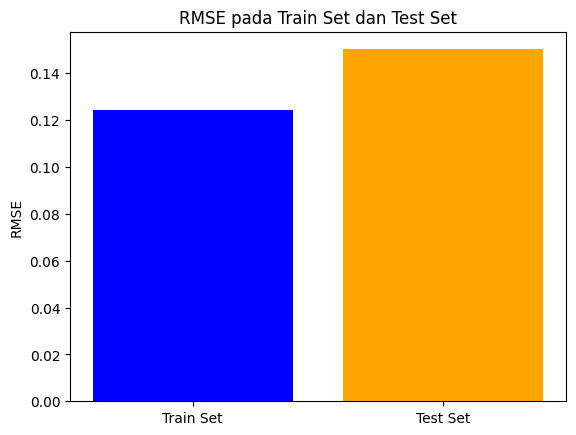

In [ ]:
# Prediksi pada train set
train_predictions = model.test(trainset.build_testset())

# Prediksi pada test set
test_predictions = model.test(testset)

# Hitung RMSE untuk train dan test set
train_rmse = accuracy.rmse(train_predictions, verbose=False)
test_rmse = accuracy.rmse(test_predictions, verbose=False)
print(f'RMSE pada Train Set: {train_rmse}')
print(f'RMSE pada Test Set: {test_rmse}')

# Plot RMSE
plt.bar(['Train Set', 'Test Set'], [train_rmse, test_rmse], color=['blue', 'orange'])
plt.title('RMSE pada Train Set dan Test Set')
plt.ylabel('RMSE')
plt.show()